#**Практическое задание №1**

Установка необходимых пакетов:

In [14]:
#!pip install -q tqdm
#!pip install --upgrade --no-cache-dir gdown
#!pip install -q torch

Монтирование Вашего Google Drive к текущему окружению:

In [15]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [16]:
EVALUATE_ONLY = True
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

Импорт необходимых зависимостей:

In [17]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown

---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [18]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        #url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
        #output = f'{name}.npz'
        #gdown.download(url, output, quiet=False)
        #print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'./{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

Done. Dataset train_tiny consists of 900 images.

Got numpy array of shape (224, 224, 3), and label with code 5.
Label code corresponds to MUS class.


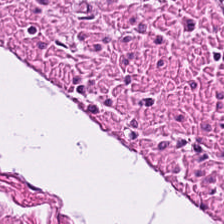

In [19]:
d_train_tiny = Dataset('train_tiny')

img, lbl = d_train_tiny.random_image_with_label()
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

### Обёртка над Dataset для использования с PyTorch

In [20]:
# ============================================================
# (Опционально) Обёртка над Dataset для использования с PyTorch
# ============================================================

# ВНИМАНИЕ:
# Этот код нужен только тем, кто хочет решать задание с помощью PyTorch.
# Он показывает, как "подключить" наш Dataset к torch.utils.data.DataLoader.

try:
    import torch
    from torch.utils.data import Dataset as TorchDataset, DataLoader
    import torchvision.transforms as T
    from PIL import Image

    class HistologyTorchDataset(TorchDataset):
        """
        Обёртка над Dataset для использования с PyTorch.

        base_dataset: экземпляр Dataset('train'), Dataset('train_small'), etc.
        transform:    функция/объект, преобразующий изображение (PIL.Image -> torch.Tensor).

        """
        def __init__(self, base_dataset, transform=None):
            self.base = base_dataset
            # Минимальный transform по умолчанию:
            # np.uint8 [0, 255] -> float32 [0.0, 1.0]
            self.transform = transform or T.ToTensor()

        def __len__(self):
            # Размер датасета
            return len(self.base.images)

        def __getitem__(self, idx):
            """
            Возвращает (image_tensor, label) для PyTorch.
            image_tensor: torch.Tensor формы [3, H, W]
            label: int
            """
            img, label = self.base.image_with_label(idx)  # img: np.ndarray (H, W, 3)
            img = Image.fromarray(img)                    # в PIL.Image
            img = self.transform(img)                     # в torch.Tensor
            return img, label

except ImportError:
    HistologyTorchDataset = None
    print("PyTorch / torchvision не найдены. Обёртка HistologyTorchDataset недоступна.")

PyTorch / torchvision не найдены. Обёртка HistologyTorchDataset недоступна.


### Пример использвания класса HistologyTorchDataset

In [21]:
if "HistologyTorchDataset" not in globals() or HistologyTorchDataset is None:
    print("PyTorch не установлен или обёртка недоступна — пример пропущен.")
else:
    print("Пример использования PyTorch-обёртки над Dataset")

    base_train = Dataset('train_tiny')

    # Создаём PyTorch-совместимый датасет
    train_ds = HistologyTorchDataset(base_train)

    # DataLoader автоматически создаёт батчи и перемешивает данные
    from torch.utils.data import DataLoader
    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)

    # Берём один батч и выводим информацию
    images_batch, labels_batch = next(iter(train_loader))

    print("Форма батча изображений:", tuple(images_batch.shape))  # [batch, 3, 224, 224]
    print("Форма батча меток:", tuple(labels_batch.shape))        # [batch]
    print("Пример меток:", labels_batch[:10].tolist())

    print("Тип images_batch:", type(images_batch))
    print("Тип labels_batch:", type(labels_batch))


PyTorch не установлен или обёртка недоступна — пример пропущен.


---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [22]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

In [23]:
#label1 — импорт
import gdown
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

#label2 — определение модели
class Model:
    def __init__(self, num_classes: int = 9):
        self.device = torch.device("cpu")
        self.num_classes = num_classes

        #label3 — сверточный фиче-экстрактор
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.1),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.1),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.15),

            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),


            #label4 — классификатор
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, self.num_classes)
        ).to(self.device)

        self.loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
        self.optimizer = optim.Adam(self.net.parameters(), lr=1e-3, weight_decay=1e-4)

        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.5,
            patience=2
        )


    #label5 — сохранение/загрузка
    def save(self, name: str):
        path = f'{name}.pth'
        torch.save(self.net.state_dict(), path)

    def load(self, name: str):
        path = f'{name}.pth'
        state = torch.load(path, map_location=self.device)
        self.net.load_state_dict(state)
        self.net.eval()


    #label6 — препроцессинг изображения
    def preprocess(self, img: np.ndarray, train=False) -> torch.Tensor:

        if img.ndim == 2:
            img = np.stack([img, img, img], axis=-1)

        if img.ndim == 3 and img.shape[0] == 3 and img.shape[2] != 3:
            img = np.transpose(img, (1, 2, 0))

        img = img.astype(np.float32)
        if img.max() > 1:
            img /= 255.0

        img = (img - 0.5) / 0.5

        img = np.transpose(img, (2, 0, 1))
        t = torch.tensor(img, dtype=torch.float32).unsqueeze(0)


        if train:

            if torch.rand(1).item() < 0.5:
                t = torch.flip(t, dims=[3])

            if torch.rand(1).item() < 0.5:
                t = nn.functional.pad(t, (4,4,4,4))
                t = nn.functional.interpolate(t, size=(224,224), mode='bilinear')

        return t.to(self.device)


    #label7 — обучение
    def train(self, dataset, epochs=25, batch_size=16):

        all_imgs = []
        all_labels = []

        for img, lbl in tqdm(zip(dataset.images_seq(dataset.n_files), dataset.labels),
                             total=dataset.n_files):
            all_imgs.append(img)
            all_labels.append(lbl)

        all_imgs = np.array(all_imgs, dtype=object)
        all_labels = np.array(all_labels)

        train_idx, val_idx = train_test_split(
            np.arange(dataset.n_files),
            test_size=0.1,
            shuffle=True,
            stratify=all_labels
        )

        print(f"Train: {len(train_idx)}, Val: {len(val_idx)}")

        self.net.train()
        best_val_loss = float('inf')

        for epoch in range(1, epochs+1):

            np.random.shuffle(train_idx)

            epoch_loss = 0
            correct = 0

            for start in tqdm(range(0, len(train_idx), batch_size),
                              desc=f"Epoch {epoch}"):

                batch_ids = train_idx[start:start+batch_size]

                Xb = []
                yb = []

                for i in batch_ids:
                    Xb.append(self.preprocess(all_imgs[i], train=True))
                    yb.append(all_labels[i])

                Xb = torch.cat(Xb, dim=0)
                yb = torch.tensor(yb, dtype=torch.long, device=self.device)

                logits = self.net(Xb)
                loss = self.loss_fn(logits, yb)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item() * len(batch_ids)
                preds = torch.argmax(logits, dim=1)
                correct += (preds == yb).sum().item()

            epoch_loss /= len(train_idx)
            acc = correct / len(train_idx)

            val_loss = 0
            val_correct = 0

            self.net.eval()
            with torch.no_grad():
                for i in val_idx:
                    xb = self.preprocess(all_imgs[i], train=False)
                    yb = torch.tensor([all_labels[i]], device=self.device)

                    logits = self.net(xb)
                    loss = self.loss_fn(logits, yb)

                    val_loss += loss.item()
                    pred = torch.argmax(logits, dim=1)
                    val_correct += (pred == yb).sum().item()

            val_loss /= len(val_idx)
            val_acc = val_correct / len(val_idx)

            print(f"[Epoch {epoch}] train_loss={epoch_loss:.4f}, "
                  f"val_loss={val_loss:.4f}, val_acc={val_acc*100:.2f}%")

            self.scheduler.step(val_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                self.save("best")
                print("Лучшая модель обновлена")

            self.net.train()

        print("Обучение завершено")



    #label8 — тестирование
    def test_on_image(self, img: np.ndarray) -> int:
        self.net.eval()
        with torch.no_grad():
            x = self.preprocess(img, train=False)
            logits = self.net(x)
            return torch.argmax(logits, dim=1).item()


    def test_on_dataset(self, dataset, limit=None):
        self.net.eval()

        n = dataset.n_files if limit is None else int(dataset.n_files * limit)

        predictions = []
        correct = 0

        for i, img in tqdm(
            enumerate(dataset.images_seq(n)),
            total=n,
            desc="Testing"
        ):
            pred = self.test_on_image(img)
            predictions.append(pred)

            if pred == dataset.labels[i]:
                correct += 1

        acc = correct / n
        print(f"Точность модели: {acc*100:.2f}%")

        return predictions


---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test_small'.

In [24]:
d_train = Dataset('train_small')
d_test = Dataset('test_small')

Done. Dataset train_small consists of 7200 images.
Done. Dataset test_small consists of 1800 images.


In [25]:
model = Model()
if not EVALUATE_ONLY:
    model.train(d_train)
    model.save('best')
else:
    #todo: your link goes here
    model.load('best')

Пример тестирования модели на части набора данных:

In [26]:
  # evaluating model on 10% of test dataset
  pred_1 = model.test_on_dataset(d_test, limit=0.1)
  Metrics.print_all(d_test.labels[:len(pred_1)], pred_1, '10% of test')

Testing:   0%|          | 0/180 [00:00<?, ?it/s]

Точность модели: 100.00%
metrics for 10% of test:
	 accuracy 1.0000:
	 balanced accuracy 1.0000:


c:\Users\ruslan\anaconda3\envs\mlPy-310\lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Пример тестирования модели на полном наборе данных:

In [27]:
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test)
    Metrics.print_all(d_test.labels, pred_2, 'test')

Testing:   0%|          | 0/1800 [00:00<?, ?it/s]

Точность модели: 95.67%
metrics for test:
	 accuracy 0.9567:
	 balanced accuracy 0.9567:


Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [28]:
final_model = Model()
final_model.load('best')
d_test_tiny = Dataset('test_tiny')
pred = final_model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

Done. Dataset test_tiny consists of 90 images.


Testing:   0%|          | 0/90 [00:00<?, ?it/s]

Точность модели: 92.22%
metrics for test-tiny:
	 accuracy 0.9222:
	 balanced accuracy 0.9222:


Отмонтировать Google Drive.

In [ ]:
drive.flush_and_unmount()

---
# Дополнительные "полезности"

Ниже приведены примеры использования различных функций и библиотек, которые могут быть полезны при выполнении данного практического задания.

### Измерение времени работы кода

Измерять время работы какой-либо функции можно легко и непринужденно при помощи функции timeit из соответствующего модуля:

In [ ]:
import timeit

def factorial(n):
    res = 1
    for i in range(1, n + 1):
        res *= i
    return res


def f():
    return factorial(n=1000)

n_runs = 128
print(f'Function f is caluclated {n_runs} times in {timeit.timeit(f, number=n_runs)}s.')

Function f is caluclated 128 times in 0.022342700001900084s.


### Scikit-learn

Для использования "классических" алгоритмов машинного обучения рекомендуется использовать библиотеку scikit-learn (https://scikit-learn.org/stable/). Пример классификации изображений цифр из набора данных MNIST при помощи классификатора SVM:

Classification report for classifier SVC(gamma=0.001):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        88
           1       0.99      0.97      0.98        91
           2       0.99      0.99      0.99        86
           3       0.98      0.87      0.92        91
           4       0.99      0.96      0.97        92
           5       0.95      0.97      0.96        91
           6       0.99      0.99      0.99        91
           7       0.96      0.99      0.97        89
           8       0.94      1.00      0.97        88
           9       0.93      0.98      0.95        92

    accuracy                           0.97       899
   macro avg       0.97      0.97      0.97       899
weighted avg       0.97      0.97      0.97       899




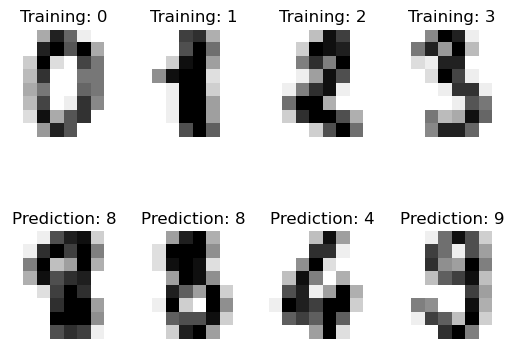

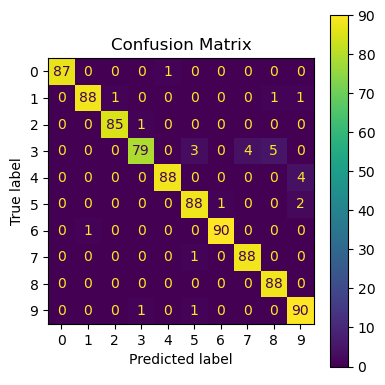

In [ ]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
predicted = classifier.predict(X_test)

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))

# Матрица ошибок + визуализация в новом API
cm = metrics.confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classifier.classes_)

fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax)
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()

### Scikit-image

Реализовывать различные операции для работы с изображениями можно как самостоятельно, работая с массивами numpy, так и используя специализированные библиотеки, например, scikit-image (https://scikit-image.org/). Ниже приведен пример использования Canny edge detector.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndi.rotate(im, 15, mode='constant')
im = ndi.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

### Tensorflow 2

Для создания и обучения нейросетевых моделей можно использовать фреймворк глубокого обучения Tensorflow 2. Ниже приведен пример простейшей нейроной сети, использующейся для классификации изображений из набора данных MNIST.

In [ ]:
# Install TensorFlow

import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test,  y_test, verbose=2)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8569 - loss: 0.4820
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9559 - loss: 0.1496
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9683 - loss: 0.1034
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9740 - loss: 0.0823
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9776 - loss: 0.0746
313/313 - 2s - 5ms/step - accuracy: 0.9781 - loss: 0.0712


[0.07115683704614639, 0.9781000018119812]

<font color="red">
Для эффективной работы с моделями глубокого обучения убедитесь в том, что в текущей среде Google Colab используется аппаратный ускоритель GPU или TPU. Для смены среды выберите "среда выполнения" -> "сменить среду выполнения".
</font>

Большое количество туториалов и примеров с кодом на Tensorflow 2 можно найти на официальном сайте https://www.tensorflow.org/tutorials?hl=ru.

Также, Вам может понадобиться написать собственный генератор данных для Tensorflow 2. Скорее всего он будет достаточно простым, и его легко можно будет реализовать, используя официальную документацию TensorFlow 2. Но, на всякий случай (если не удлось сразу разобраться или хочется вникнуть в тему более глубоко), можете посмотреть следующий отличный туториал: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

### PyTorch

In [ ]:
# ============================================================
# Дополнительно: мини-демо PyTorch
# ============================================================
# Ранний выход, если PyTorch/обёртка недоступны
try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import DataLoader
except ImportError:
    print("PyTorch не установлен — демо пропущено.")
    import sys
    raise SystemExit

if "HistologyTorchDataset" not in globals() or HistologyTorchDataset is None:
    print("HistologyTorchDataset недоступна — демо пропущено.")
    import sys
    raise SystemExit


# --- Данные: tiny-наборы, чтобы выполнялось быстро ---
base_train = Dataset('train_tiny')
base_test  = Dataset('test_tiny')

train_ds = HistologyTorchDataset(base_train)           # ToTensor по умолчанию
test_ds  = HistologyTorchDataset(base_test)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

# --- Мини-модель: двухслойный CNN + один FC (демонстрация, не решение) ---
class TinyCNN(nn.Module):
    def __init__(self, num_classes=len(TISSUE_CLASSES)):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)  # 224->112->56
        self.fc    = nn.Linear(16 * 56 * 56, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 3, 224, 224] -> [B, 8, 112, 112]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 8, 112, 112] -> [B, 16, 56, 56]
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = TinyCNN(num_classes=len(TISSUE_CLASSES)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- Один учебный шаг "обучения" на одном батче ---
model.train()
xb, yb = next(iter(train_loader))
xb = xb.to(device)
yb = yb.to(device, dtype=torch.long)

optimizer.zero_grad()
logits = model(xb)
loss = criterion(logits, yb)
float_loss = float(loss.detach().cpu())
loss.backward()
optimizer.step()

print(f"Loss на одном батче train_tiny: {float_loss:.4f}")

# --- Быстрая проверка на одном батче теста (для формы вывода/метрик) ---
model.eval()
with torch.no_grad():
    xt, yt = next(iter(test_loader))
    xt = xt.to(device)
    logits_t = model(xt).cpu()
    y_pred = logits_t.argmax(dim=1).numpy()
    y_true = yt.numpy()

print("Размерности:", {"y_true": y_true.shape, "y_pred": y_pred.shape})
Metrics.print_all(y_true, y_pred, "_")  # balanced accuracy/accuracy на одном батче для демонстрации

# для полноценного решения требуется собственный тренировочный цикл по эпохам,
# аугментации/нормализация, сохранение/загрузка весов, и тестирование на всём наборе.

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui
To: /content/train_tiny.npz
100%|██████████| 105M/105M [00:00<00:00, 181MB/s] 


Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1viiB0s041CNsAK4itvX8PnYthJ-MDnQc
To: /content/test_tiny.npz
100%|██████████| 10.6M/10.6M [00:00<00:00, 186MB/s]


Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.
Device: cuda
Loss на одном батче train_tiny: 2.1867
Размерности: {'y_true': (32,), 'y_pred': (32,)}
metrics for _:
	 accuracy 0.0000:
	 balanced accuracy 0.0000:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


### Дополнительные ресурсы по PyTorch

- **Официальные туториалы PyTorch** — https://pytorch.org/tutorials/  
- **“Deep Learning with PyTorch: 60-Minute Blitz”** — https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
- **Transfer Learning for Computer Vision** — https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html  
- **PyTorch Get Started (установка)** — https://pytorch.org/get-started/locally/  
- **Dive into Deep Learning (D2L, глава PyTorch)** — https://d2l.ai/chapter_preliminaries/index.html  
- **Fast.ai — Practical Deep Learning for Coders** — https://course.fast.ai/  
- **Learn PyTorch.io (Zero to Mastery)** — https://www.learnpytorch.io/

### Numba

В некоторых ситуациях, при ручных реализациях графовых алгоритмов, выполнение многократных вложенных циклов for в python можно существенно ускорить, используя JIT-компилятор Numba (https://numba.pydata.org/).
Примеры использования Numba в Google Colab можно найти тут:
1. https://colab.research.google.com/github/cbernet/maldives/blob/master/numba/numba_cuda.ipynb
2. https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/COMPASS_gpu_intro.ipynb

> Пожалуйста, если Вы решили использовать Numba для решения этого практического задания, еще раз подумайте, нужно ли это Вам, и есть ли возможность реализовать требуемую функциональность иным способом. Используйте Numba только при реальной необходимости.



### Работа с zip архивами в Google Drive

Запаковка и распаковка zip архивов может пригодиться при сохранении и загрузки Вашей модели. Ниже приведен фрагмент кода, иллюстрирующий помещение нескольких файлов в zip архив с последующим чтением файлов из него. Все действия с директориями, файлами и архивами должны осущетвляться с примонтированным Google Drive.


Создадим 2 изображения, поместим их в директорию tmp внутри PROJECT_DIR, запакуем директорию tmp в архив tmp.zip.

In [ ]:
PROJECT_DIR = "/dev/prak_nn_1/"
arr1 = np.random.rand(100, 100, 3) * 255
arr2 = np.random.rand(100, 100, 3) * 255

img1 = Image.fromarray(arr1.astype('uint8'))
img2 = Image.fromarray(arr2.astype('uint8'))

p = "/content/drive/MyDrive/" + PROJECT_DIR

if not (Path(p) / 'tmp').exists():
    (Path(p) / 'tmp').mkdir()

img1.save(str(Path(p) / 'tmp' / 'img1.png'))
img2.save(str(Path(p) / 'tmp' / 'img2.png'))

%cd $p
!zip -r "tmp.zip" "tmp"

Распакуем архив tmp.zip в директорию tmp2 в PROJECT_DIR. Теперь внутри директории tmp2 содержится директория tmp, внутри которой находятся 2 изображения.

In [ ]:
p = "/content/drive/MyDrive/" + PROJECT_DIR
%cd $p
!unzip -uq "tmp.zip" -d "tmp2"